In [11]:
import pandas as pd
import random
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
from main_functions import *

In [2]:
figures_path = "figures/"

In [3]:
DATA = 'data/'

In [4]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
get_name = dict(zip(proteins, protein_names))
measures = ['nodes', 'edges', 'weight', 'distance']

In [5]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]

In [6]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [7]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [8]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

## Spearman correlations

In [12]:
def SpearmanR(protein, measure):
    '''Return list with Spearman correlation coefficient between mean functional data and mean perturbation network 
    data for measure by threshold. '''
    functional_mean = list(functional_data[protein].mean())
    correlations = []
    for threshold in thresholds:
        network_data = ReadNetworkCSV(protein, threshold, measure)
        network_mean = list(network_data.mean())
        correlations.append(round(stats.spearmanr(functional_mean, network_mean)[0], 3))
    return correlations

In [13]:
correlations = dict()
for measure in measures:
    for protein in proteins:
        correlations[(protein, measure)] = SpearmanR(protein, measure)

In [19]:
proteins

['1be9', '1d5r', '1nd4', '3dqw', '4bz3']

In [38]:
correlations[('4bz3', 'distance')][:15]

[-0.376,
 -0.414,
 -0.424,
 -0.43,
 -0.47,
 -0.483,
 -0.486,
 -0.425,
 -0.374,
 -0.34,
 -0.348,
 -0.349,
 -0.313,
 -0.34,
 -0.253]

In [25]:
# control protein, we considered the protein 4bz3 (VIM2) as a representative. We considered a random permutation of 
# its positions, and for each measure and threshold, calculated the correlation between the original functional mean 
# value at each position and the corresponding perturbation score at the position given by the permutation. 
functional_mean = list(functional_data['4bz3'].mean())

# store results in dict 
results = {measure:[] for measure in measures}

for i in range(100):
    shuffled_positions = list(functional_data['4bz3'].columns).copy()
    random.shuffle(shuffled_positions) 
    for measure in measures:
        corr = []
        for threshold in thresholds:
            network_data = ReadNetworkCSV('4bz3', threshold, measure)
            network_mean = network_data.mean()
            shuffled_mean = [network_mean[pos] for pos in shuffled_positions]
            corr.append(round(sp.stats.spearmanr(functional_mean, shuffled_mean)[0], 3))
        results[measure].append(corr)
        
# add to correlations dict from above
for measure in measures:
    array = np.array(results[measure])
    correlations[('control', measure)] = array.mean(axis=0)

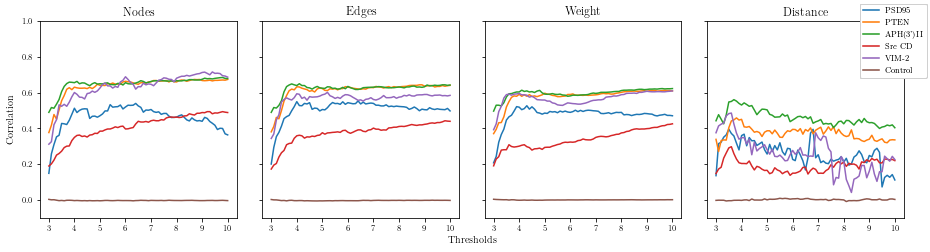

In [32]:
labels1 = ['Nodes', 'Edges', 'Weight', 'Distance']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13,3.5), sharex=True, sharey=True)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.tight_layout()
plt.ylabel('Correlation')
plt.xlabel('Thresholds')

for i, measure in enumerate(measures):
    ax = axes[i]
    ax.set_ylim(-0.1,1)
    for j,protein in enumerate(proteins):
        ax.plot(thresholds, [abs(c) for c in correlations[(protein, measure)]], label=protein_names[j])
    ax.plot(thresholds, correlations[('control', measure)], label='Control')
    ax.set_title(labels1[i])
    ax.set_aspect(1./ax.get_data_ratio())
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)

fig.savefig("figures/correlations.png", bbox_inches='tight', dpi=300)